In [1]:
from sklearn import preprocessing
import numpy as np
from numpy import genfromtxt
import pandas as pd
import matplotlib.pyplot as plt

def read_data_file(filename):
    Data = pd.read_csv(filename,low_memory = False)

    # Drop unneccessary columns #

    Data = Data.drop('Vehicle_Annual_Miles', 1)
    Data = Data.drop('Vehicle_Comprehensive_Coverage_Limit', 1)
    Data = Data.drop('Driver_Minimum_Age', 1)
    Data = Data.drop('Driver_Maximum_Age', 1)
    Data = Data.drop('EEA_PolicyYear', 1)
    Data = Data.drop('Vehicle_New_Cost_Amount', 1)
    Data = Data.drop('Vehicle_Make_Description', 1)
    Data = Data.drop('EEA_Policy_Zip_Code_3', 1)
    # Clearing unneccessary rows #

    Data = Data[Data.EEA_Policy_Tenure != -1]
    Data = Data[Data.Vehicle_Symbol != -1]
    Data = Data[Data.Vehicle_Days_Per_Week_Driven != -1]
    Data = Data[Data.Vehicle_Anti_Theft_Device != 'Unknown']

    # Replace missing Data #

    Data['Policy_Zip_Code_Garaging_Location'] = Data['Policy_Zip_Code_Garaging_Location'].replace('Unknown', '00000')
    Data['Vehicle_Miles_To_Work'] = Data['Vehicle_Miles_To_Work'].replace('-1', np.nan)
    Data['Vehicle_Passive_Restraint'] = Data['Vehicle_Passive_Restraint'].replace('Unknown', 'Y')
    # Data['EEA_Policy_Zip_Code_3'] = Data['EEA_Policy_Zip_Code_3'].replace('Unknown', '000')
    Data['Vehicle_Med_Pay_Limit'] = Data['Vehicle_Med_Pay_Limit'].replace('-1', np.nan)
    Data['Vehicle_Physical_Damage_Limit'] = Data['Vehicle_Physical_Damage_Limit'].replace('-1', np.nan)
    Data['Vehicle_Collision_Coverage_Deductible'] = Data['Vehicle_Collision_Coverage_Deductible'].replace('-1', np.nan)
    # Data['EEA_Prior_Bodily_Injury_Limit'] = Data['EEA_Prior_Bodily_Injury_Limit'].replace('-1', np.nan)
    # Fill nan data #

    Data['Vehicle_Miles_To_Work'].fillna((Data['Vehicle_Miles_To_Work'].mean()), inplace=True)
    Data['Vehicle_Med_Pay_Limit'].fillna((Data['Vehicle_Med_Pay_Limit'].mean()), inplace=True)
    Data['EEA_Prior_Bodily_Injury_Limit'].fillna('0000', inplace=True)
    Data['Vehicle_Bodily_Injury_Limit'].fillna('0000', inplace=True)
    Data['Vehicle_Physical_Damage_Limit'].fillna('0000', inplace=True)
    Data['Vehicle_Collision_Coverage_Deductible'].fillna('0000', inplace=True)

    # move to after splitting up data
    # #Categorizing continuous data #

    # Data['Vehicle_Miles_To_Work']=pd.cut(Data['Vehicle_Miles_To_Work'], bins=[0, 20,40,60,80,100], include_lowest=True, labels=['lowest', 'low', 'mid', 'high', 'highest'])

    # Data['Annual_Premium'] = pd.cut(Data['Annual_Premium'],9, include_lowest=True , labels= ['highest', 'very high', 'moderately high', 'higher', 'medium', 'lower', 'moderately low', 'very low', 'lowest'])

    # Save modified data to new csv file #

    # Data.to_csv('new_data.csv', sep=',', encoding='utf-8')
    return Data

Data = read_data_file('training_data_2016.csv')

In [2]:
print(Data.shape)

(424341, 60)


In [3]:
# get some training and test data sets
category_training_data_size = 200000
claims_training_data_size = 200000
testing_data_size = 1000
number_test_sets = 100

# get data with equal number claims and not
category_training_data = Data[:category_training_data_size].copy(deep=True)

#Categorizing continuous data #

category_training_data['Vehicle_Miles_To_Work']=pd.cut(category_training_data['Vehicle_Miles_To_Work'], bins=[0, 20,40,60,80,100], include_lowest=True, labels=['lowest', 'low', 'mid', 'high', 'highest'])

category_training_data['Annual_Premium'] = pd.cut(category_training_data['Annual_Premium'],9, include_lowest=True , labels= ['highest', 'very high', 'moderately high', 'higher', 'medium', 'lower', 'moderately low', 'very low', 'lowest'])


claims_training_data = Data[:category_training_data_size].copy(deep=True)#Data[category_training_data_size: category_training_data_size + claims_training_data_size].copy(deep=True)


training_data_size = 200000#category_training_data_size + claims_training_data_size
test_sets = []
for i in range(number_test_sets):
    t_set = Data[training_data_size + i * testing_data_size: training_data_size + (i + 1) * testing_data_size].copy(deep=True)
    test_sets.append(t_set)

In [188]:
# train model to decide claim or not

from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from scipy.sparse import csc_matrix
from scipy.sparse import csr_matrix

clf = DecisionTreeClassifier()

X_t = category_training_data.ix[:, 0:-5]
Y_t = category_training_data.ix[:, -4]

for col in X_t[1:]:
    X_t[col] = X_t[col].astype('category')

X_t = X_t.apply(lambda x: x.cat.codes)
Y_t = Y_t.apply(lambda x: 1 if x > 0 else 0)


from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore')

X_t = enc.fit_transform(X_t)  
# print(cross_val_score(clf, X_t, Y_t))

print(X_t.shape)

clf.fit(csc_matrix(X_t), Y_t)

print("Done!")



(200000, 2087)
Done!


In [5]:
from sklearn.ensemble import RandomForestClassifier

# category_training_data_with_claim = category_training_data[category_training_data.Claim_Count > 0].copy(deep=True)
# category_training_data_without_claims = category_training_data[category_training_data.Claim_Count == 0]
# truncated_without_claims = category_training_data_without_claims.head(n=category_training_data_with_claim.shape[0])

# category_training_data = pd.concat([category_training_data_with_claim, truncated_without_claims])

rfc = RandomForestClassifier(max_features='sqrt')#, max_depth=20)

X_t = category_training_data.ix[:, 0:-5]
Y_t = category_training_data.ix[:, -4]

for col in X_t[1:]:
    X_t[col] = X_t[col].astype('category')

X_t = X_t.apply(lambda x: x.cat.codes)
Y_t = Y_t.apply(lambda x: 1 if x > 0 else 0)

from sklearn.feature_selection import RFE
from sklearn.linear_model import Ridge
from sklearn.svm import SVR
estimator = SVR(kernel="linear")

model = Ridge()
# rfe = RFE(estimator)
rfe = RFE(model, 23)
fit = rfe.fit(X_t, Y_t)
print("Num Features: ", fit.n_features_)
print("Selected Features: ", fit.support_)
print("Feature Ranking: ", fit.ranking_)

# rel_names = [Data.columns.values[i] for i in range(X.shape[1]) if fit.support_[i]]

# print(rel_names)

from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore')

# X_t = enc.fit_transform(X_t)  
# print(cross_val_score(clf, X_t, Y_t))

X_t=fit.transform(X_t)

print(X_t.shape)
rfc.fit(X_t, Y_t)

print("Done!")

Num Features:  23
Selected Features:  [ True  True  True  True False False False False False False False False
 False  True False  True False False False False False  True  True  True
 False  True False False  True  True  True False  True False False False
 False False False False  True False  True  True  True  True False False
 False  True  True False  True False  True]
Feature Ranking:  [ 1  1  1  1  2 32 19 25 23 30 26 27 18  1 16  1 14 29 21 17 11  1  1  1 24
  1 22  3  1  1  1 15  1  9 10  7  6  5  8  4  1 13  1  1  1  1 12 31 28  1
  1 20  1 33  1]
(200000, 23)
Done!


In [341]:
from scipy.sparse import csr_matrix
# print(cross_val_score(clf, X_t, Y_t, cv=10))
predictions = []
measureds = []
for i in range(len(test_sets)):
    X_t = test_sets[i].ix[:, 0:-5]
    Y_t = test_sets[i].ix[:, -4]
    for col in X_t:
        X_t[col] = X_t[col].astype('category')
    X_t = X_t.apply(lambda x: x.cat.codes)
    Y_t = Y_t.apply(lambda x: 1 if x > 0 else 0)
#     X_t = enc.transform(X_t)
    
#     prediction = clf.predict(csr_matrix(X_t))
    prediction = rfc.predict(fit.transform(X_t))
    predictions.append(prediction)
    measureds.append(Y_t.values)
    
print("Done!")

Done!


In [ ]:
for i in range (len(measureds)):
    print('**************************')
    print("Test set ", i)
    t = list(zip( measureds[i], predictions[i]))

    correct_claims = [1 if x[0]==x[1] and x[1] else 0 for x in t ]
    false_positives = [1 if x[0]!=x[1] and x[1]==1 else 0 for x in t ]
    misclass = [1 if x[0]!=x[1] else 0 for x in t ]
    print ("Correct claims:", sum(correct_claims))
    print("False positives:", sum(false_positives))
    print("Total actual claims:", sum(measureds[i]))
    print("Total predicted:", sum(predictions[i]))
    print("total micalssed",i, sum(misclass))

In [8]:
# get scaled data sets
from sklearn.preprocessing import StandardScaler  
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

# pca = PCA(n_components=.95)

categorical_columns = ['Policy_Company', 'Policy_Installment_Term', 'Policy_Billing_Code', 'Policy_Method_Of_Payment', 'Policy_Reinstatement_Fee_Indicator', 'Policy_Zip_Code_Garaging_Location', 'Vehicle_Performance', 'Vehicle_Number_Of_Drivers_Assigned', 'Vehicle_Usage', 'Vehicle_Anti_Theft_Device', 'Vehicle_Passive_Restraint', 'Vehicle_Med_Pay_Limit', 'Vehicle_Bodily_Injury_Limit', 'Vehicle_Comprehensive_Coverage_Indicator', 'Vehicle_Comprehensive_Coverage_Limit', 'Vehicle_Collision_Coverage_Indicator', 'Vehicle_Collision_Coverage_Deductible', 'Vehicle_Youthful_Driver_Indicator', 'Vehicle_Youthful_Driver_Training_Code', 'Vehicle_Youthful_Good_Student_Code', 'Vehicle_Safe_Driver_Discount_Indicator', 'EEA_Liability_Coverage_Only_Indicator', 'EEA_Multi_Auto_Policies_Indicator', 'EEA_Policy_Zip_Code_3', 'EEA_Agency_Type', 'EEA_Packaged_Policy_Indicator', 'EEA_Full_Coverage_Indicator', 'EEA_Prior_Bodily_Injury_Limit', 'SYS_Renewed', 'SYS_New_Business']

for col in claims_training_data.ix[1:]:
    if col in categorical_columns:
        claims_training_data[col] = claims_training_data[col].astype('category')
#     print (Data[col].unique())
#     print Data[col].columns
#print Data[1].unique()
#print list(Data.columns.values)
#print(Data.head())
cat_columns = claims_training_data.select_dtypes(['category']).columns
# print("OBJECT:",claims_training_data.select_dtypes(['object']).columns)
# print("CAT Columns",cat_columns)
claims_training_data[cat_columns] = claims_training_data[cat_columns].apply(lambda x: x.cat.codes)

claims_training_data_with_claim = claims_training_data[claims_training_data.Claim_Count > 0].copy(deep=True)
claims_training_data_without_claims = claims_training_data[claims_training_data.Claim_Count == 0]
truncated_without_claims = claims_training_data_without_claims.head(n=8*claims_training_data_with_claim.shape[0])

claims_training_data = claims_training_data_with_claim#pd.concat([claims_training_data_with_claim, truncated_without_claims])

print("With claims", claims_training_data_with_claim.shape)
print("without", claims_training_data_without_claims.shape)
print(claims_training_data.shape)
    
def run_fit_reg(hiddenLayerssize, claims_training_data):
    

    X = claims_training_data.ix[:,0:-5]
    losses = claims_training_data.ix[:,-4]
    Y = losses#np.divide(losses, premium)
    # scaler_x = StandardScaler()  
    # print(X)
    # X = pca.fit_transform(X)
    # print("X after pca", X)
    # X = scaler_x.fit_transform(X)  

    pipeline = Pipeline([('scaling', StandardScaler()), ('pca', PCA(n_components=.95))])

    X = pipeline.fit_transform(X)

    print(X.shape)

    from sklearn.neural_network import MLPRegressor

    mlp = MLPRegressor(max_iter=2000, hidden_layer_sizes=(hiddenLayerssize,hiddenLayerssize))#, hiddenLayerssize))

    mlp.fit(X, Y)

    print("Done!")
    return pipeline, mlp

With claims (7864, 60)
without (0, 60)
(7864, 60)


In [ ]:
error=[]
for j in range(10, 100):
    pipeline, mlp = run_fit_reg(j, claims_training_data.copy(deep=True))
    predictions = []
    measureds = []
    scores = []
    for i in range(3):#len(test_sets)):
        X_t = test_sets[i].ix[:,0:-5]
        Y_t = test_sets[i].ix[:,-4]
        premium = sum(X_t.ix[:,-1])
        for col in X_t.ix[1:]:
            if col in categorical_columns:
                X_t[col] = X_t[col].astype('category')
        X_t[cat_columns] = X_t[cat_columns].apply(lambda x: x.cat.codes)
    #     X_t = pca.transform(X_t)
        X_t = pipeline.transform(X_t)
        prediction = mlp.predict(X_t)
        prediction = sum(prediction)#scaler_y.inverse_transform(prediction))
        measured = sum(Y_t)#scaler_y.inverse_transform(Y_t))
#         score = mlp.score(X_t, Y_t)
    #     print(prediction, premium, prediction / premium)
        predictions.append(prediction / premium)
        measureds.append(measured / premium)
#         scores.append(score)
    error.append(mean_squared_error(measureds, predictions))
    print(j, mean_squared_error(measureds, predictions))
plt.plot(error, 'r--')
plt.show()

In [35]:
# plt.plot(predictions, 'r--')
# plt.plot(measureds)
# plt.show()

In [36]:
# print (np.corrcoef(predictions,measureds))

In [9]:
# run both models
pipeline, mlp = run_fit_reg(10, claims_training_data)


#get classifications

predicted_claims = []
measureds = []
for i in range(len(test_sets)):
    X_t = test_sets[i].ix[:, 0:-5].copy(deep=True)
    Y_t = test_sets[i].ix[:, -4].copy(deep=True)
    for col in X_t:
        X_t[col] = X_t[col].astype('category')
    X_t = X_t.apply(lambda x: x.cat.codes)
    Y_t = Y_t.apply(lambda x: 1 if x > 0 else 0)
#     X_t = enc.transform(X_t)
#     X_t = t_svd.transform(X_t)
#     prediction = clf.predict(csr_matrix(X_t))
    prediction = rfc.predict(fit.transform(X_t))
    
    predicted_claims.append(prediction)
    measureds.append(Y_t.values)
    
# grab each record that will likely have a claim and predict    


predictions = []
measureds = []
scores = []
for i in range(len(test_sets)):
    
    X_t = test_sets[i].ix[:,0:-5].copy(deep=True)
    Y_t = test_sets[i].ix[:,-4].copy(deep=True)
    premium = sum(X_t.ix[:,-1])
    measured = sum(Y_t)
    
    k = 0
    for j in range(X_t.shape[0]):#range(len(predicted_claims[i])):
        if predicted_claims[i][j] == 0:
            X_t.drop(X_t.index[k], inplace=True)
            Y_t.drop(Y_t.index[k], inplace=True)
        else:
            k = k + 1
            
    
    for col in X_t.ix[1:]:
        if col in categorical_columns:
            X_t[col] = X_t[col].astype('category')
    X_t[cat_columns] = X_t[cat_columns].apply(lambda x: x.cat.codes)
    
    X_t = pipeline.transform(X_t)
    prediction = mlp.predict(X_t)
    prediction = sum(prediction)
    
    predictions.append(prediction / premium)
    measureds.append(measured / premium)

print("Done!")


(7864, 37)
Done!
Done!


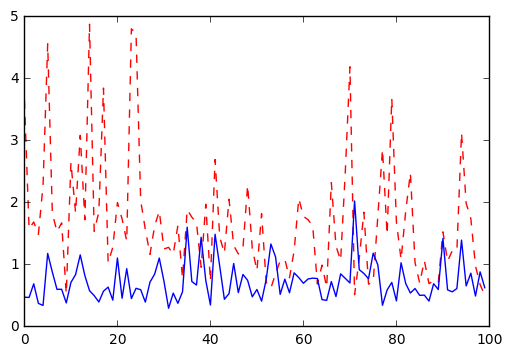

In [10]:
plt.plot(predictions, 'r--')#np.divide(predictions, 10), 'r--')
plt.plot(measureds)
plt.show()

In [11]:
from sklearn.metrics import mean_squared_error
print(mean_squared_error(measureds, predictions))
print (np.corrcoef(predictions,measureds))

1.93570812638
[[ 1.         0.0083403]
 [ 0.0083403  1.       ]]


In [ ]:
# read in 600 excel files lol 
predictions = []
for i in range(1,601):
    file_name = "test_portfolios/test_portfolio_"+str(i)+".csv"
    TestData = read_data_file(file_name)
#     print(TestData.shape)
#     print(type(TestData))
    TestData = TestData.drop('PolicyNo', 1)
    X_t = TestData
    premium = sum(X_t.ix[:,-1])
    print("Premium:", premium)
    for col in X_t:
        X_t[col] = X_t[col].astype('category')
    X_t = X_t.apply(lambda x: x.cat.codes)
    
    # classificaztaion
    
    prediction = rfc.predict(fit.transform(X_t))
    predicted_claims = prediction
#     print ("Predicted claims:", predicted_claims)
    #regression
    X_t = TestData
    k = 0
    for j in predicted_claims:
        if j == 0:
            X_t.drop(X_t.index[k], inplace=True)
        else:
            k = k + 1
            
    for col in X_t:
        if col in categorical_columns:
            X_t[col] = X_t[col].astype('category')
    X_t[cat_columns] = X_t[cat_columns].apply(lambda x: x.cat.codes)
    
    X_t = pipeline.transform(X_t)
    prediction = mlp.predict(X_t)
    prediction = sum(prediction)
    
    print("Sum Predicitpon", prediction)
    predictions.append(prediction / premium)
    
print(predictions)

Premium: 331804.8
Sum Predicitpon 137202.776255
Premium: 324489.52
Sum Predicitpon 551264.377826
Premium: 343187.79
Sum Predicitpon 421864.78461
Premium: 334752.63
Sum Predicitpon 102533.282573
Premium: 342738.63
Sum Predicitpon 227627.191794
Premium: 326778.89
Sum Predicitpon 417880.259609
Premium: 334008.46
Sum Predicitpon 82485.9813206
Premium: 336235.57
Sum Predicitpon 188230.072618
Premium: 333513.01
Sum Predicitpon 185440.363022
Premium: 343363.38
Sum Predicitpon 191996.358372
Premium: 324789.9
Sum Predicitpon 201699.419545
Premium: 321688.33
Sum Predicitpon 115921.595961
Premium: 332085.3
Sum Predicitpon 64647.6658315
Premium: 332177.78
Sum Predicitpon 219127.832855
Premium: 325444.1
Sum Predicitpon 210647.932082
Premium: 329539.84
Sum Predicitpon 172142.44185
Premium: 327755.29
Sum Predicitpon 129749.024185
Premium: 344456.51
Sum Predicitpon 202312.85081
Premium: 341293.2
Sum Predicitpon 351428.736637
Premium: 343888.5
Sum Predicitpon 100116.861821
Premium: 342229.94
Sum Predic